In [2]:
import os
import sys
import inspect

# Insert modules directory, TODO create setup.py file
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
reports_dir = os.path.dirname(currentdir)
project_home_dir = os.path.dirname(reports_dir)
sys.path.insert(0, f"{project_home_dir}/qcnn")

In [3]:
import numpy as np
import pandas as pd
from pprint import pprint
from reporting_functions import (
    get_file_content,
    get_result_table,
    get_result_table_target_pairs,
)
from joblib import dump, load
from collections import namedtuple
from circuit_presets import get_wire_combos

In [4]:
experiments_path = f"{project_home_dir}/experiments"
experiment_filename = "experiment.json"
target_levels = [
    "classical",
    "country",
    "rock",
    "pop",
    "hiphop",
    "jazz",
    "blues",
    "disco",
    "metal",
    "reggae",
]

In [5]:
experiment_id = 122
experiment_config = get_file_content(
    f"{experiments_path}/{experiment_id}/{experiment_filename}"
)

In [6]:
pprint(experiment_config)

{'ID': 122,
 'data': {'path': '/home/matt/dev/projects/quantum-cnn/data/archive/Data/features_30_sec.csv',
          'sampling': {'random_state': 42, 'test_size': 0.3},
          'target_column': 'label',
          'target_pairs': [['classical', 'pop'], ['rock', 'reggae']],
          'type': '2d'},
 'extra_info': 'Building the QCNN one layer at a time but trying to see when '
               'it starts to perform',
 'model': {'classical': {'cnn': {'ignore': True, 'param_grid': {}},
                         'logistic_regression': {'ignore': True,
                                                 'param_grid': {'C': [0.001,
                                                                      0.01,
                                                                      0.1,
                                                                      1.0,
                                                                      10.0,
                                                                      

In [7]:
path = f"{experiment_config.get('path')}/{experiment_config.get('ID')}"

In [8]:
y_test = pd.read_csv(f"{path}/y_test.csv", index_col=0)
X_test = pd.read_csv(f"{path}/X_test.csv", index_col=0)

In [9]:
model_names = [
    filename.split("-model_configuration.joblib")[0]
    for filename in os.listdir(path)
    if "-model_configuration.joblib" in filename
]

In [10]:
# Gather results
Results = namedtuple(
    "Results", ["model_name", "y_test_hat", "clf", "model_configuration", "samples_tfd", "pipeline"]
)
result_list = []
for model_name in model_names:
    y_test_hat = pd.read_csv(f"{path}/{model_name}-yhat.csv", index_col=0)
    clf = load(f"{path}/{model_name}-clf_results.joblib")
    model_configuration = load(f"{path}/{model_name}-model_configuration.joblib")
    samples_tfd = load(f"{path}/{model_name}-samples_tfd.joblib")
    pipeline = load(f"{path}/{model_name}-pipeline.joblib")
    result_list = result_list + [
        Results(
            model_name,
            y_test_hat=y_test_hat,
            clf=clf,
            model_configuration=model_configuration,
            samples_tfd=samples_tfd,
            pipeline=pipeline,
        )
    ]
print(len(result_list))

192


In [11]:
# Table
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

result_data = pd.DataFrame(
    {
        "model_name": [],
        "model_type": [],
        "algorithm": [],
        "classification_type": [],
        "embedding_type": [],
        "scaler_method": [],
        "scaler_param_str": [],
        "selection_method": [],
        "selection_param_str": [],
        "target_pair": [],
        "additional_structure": [],
        "additional_structure_str": [],
        "circuit":[],
        "target_pair_str": [],
        "mean_test_score": [],
        "std_test_score": [],
        "top_features": [],
        "params": [],
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1": [],
        "loss_train_history": [],
    }
)
for result in result_list:
    y_test_hat = result.y_test_hat
    clf = result.clf
    model_configuration = result.model_configuration
    samples_tfd = result.samples_tfd
    model_name = result.model_name

    precision, recall, fscore, support = precision_recall_fscore_support(
        samples_tfd.y_test, y_test_hat, average="binary"  # TODO multiclass
    )
    accuracy = accuracy_score(samples_tfd.y_test, y_test_hat)
    tmp_result = model_configuration._asdict()
    tmp_result["model_name"] = model_name

    tmp_result["target_pair_str"] = "_".join(model_configuration.target_pair)
    tmp_result["additional_structure_str"] = f"{model_configuration.additional_structure[0]}_{model_configuration.additional_structure[1]}_{model_configuration.additional_structure[2]}"
    tmp_result["circuit"] = model_configuration.additional_structure[0]
    tmp_result["mean_test_score"] = clf.cv_results_["mean_test_score"][clf.best_index_]
    tmp_result["std_test_score"] = clf.cv_results_["std_test_score"][clf.best_index_]
    tmp_result["params"] = clf.cv_results_["params"][clf.best_index_]
    
    if result.model_configuration.selection_method == "tree":
        tmp_result["top_features"] = X_test.columns[result.pipeline.named_steps.get("tree")._get_support_mask()]
    else:
        tmp_result["top_features"] = None

    tmp_result["accuracy"] = accuracy
    tmp_result["precision"] = precision
    tmp_result["recall"] = recall
    tmp_result["f1"] = fscore
    tmp_result["loss_train_history"] = None  # set for quantum
    result_data = result_data.append(tmp_result, ignore_index=True)

In [12]:
result_data.fillna("None", inplace=True)
result_data.head()

,model_name,model_type,algorithm,classification_type,embedding_type,scaler_method,scaler_param_str,selection_method,selection_param_str,target_pair,...,target_pair_str,mean_test_score,std_test_score,top_features,params,accuracy,precision,recall,f1,loss_train_history
0,quantum-qcnn-binary-Angle-minmax-n_components=...,quantum,qcnn,binary,Angle,minmax,n_components=8,pca,"feature_range=[0, 1.5707963267948966]","[rock, reggae]",...,rock_reggae,-11.217885,1.682162,None,{'n_iter': 50},0.750000,0.724138,0.724138,0.724138,None
1,quantum-qcnn-binary-Angle-minmax-n_components=...,quantum,qcnn,binary,Angle,minmax,n_components=8,pca,"feature_range=[0, 1.5707963267948966]","[rock, reggae]",...,rock_reggae,-11.561638,1.885520,None,{'n_iter': 50},0.734375,0.730769,0.655172,0.690909,None
2,quantum-qcnn-binary-Angle-minmax-max_features=...,quantum,qcnn,binary,Angle,minmax,max_features=8_n_estimators=50,tree,"feature_range=[0, 1.5707963267948966]","[classical, pop]",...,classical_pop,-8.378233,1.593510,"Index(['mfcc5_var', 'chroma_stft_var', 'mfcc15...",{'n_iter': 50},0.883721,1.000000,0.782609,0.878049,None
3,quantum-qcnn-binary-Angle-minmax-max_features=...,quantum,qcnn,binary,Angle,minmax,max_features=8_n_estimators=50,tree,"feature_range=[0, 1.5707963267948966]","[classical, pop]",...,classical_pop,-8.693634,1.717612,"Index(['mfcc5_var', 'mfcc16_var', 'mfcc15_var'...",{'n_iter': 50},0.953488,1.000000,0.913043,0.954545,None
4,quantum-qcnn-binary-Angle-minmax-max_features=...,quantum,qcnn,binary,Angle,minmax,max_features=8_n_estimators=50,tree,"feature_range=[0, 1.5707963267948966]","[rock, reggae]",...,rock_reggae,-12.899935,1.492913,"Index(['mfcc10_mean', 'mfcc20_var', 'mfcc18_va...",{'n_iter': 50},0.734375,0.650000,0.896552,0.753623,None


In [13]:
experiment_config["model"]["quantum"]["qcnn"].get("wire_pattern_list")

[[8, 1, 'left'],
 [8, 1, 'right'],
 [8, 1, 'eo_even'],
 [8, 1, 'eo_odd'],
 [8, 1, 'inside'],
 [8, 1, 'outside'],
 [8, 3, 'left'],
 [8, 3, 'right'],
 [8, 3, 'eo_even'],
 [8, 3, 'eo_odd'],
 [8, 3, 'inside'],
 [8, 3, 'outside'],
 [8, 5, 'left'],
 [8, 5, 'right'],
 [8, 5, 'eo_even'],
 [8, 5, 'eo_odd'],
 [8, 5, 'inside'],
 [8, 5, 'outside'],
 [8, 7, 'left'],
 [8, 7, 'right'],
 [8, 7, 'eo_even'],
 [8, 7, 'eo_odd'],
 [8, 7, 'inside'],
 [8, 7, 'outside']]

In [14]:
wire_combo = [8, 1, 'eo_even']
print(wire_combo)
get_wire_combos(wire_combo[0], wire_combo[1], wire_combo[2])

[8, 1, 'eo_even']


{'c_1': [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 0)],
 'p_1': [(0, 1), (2, 3), (4, 5), (6, 7)],
 'c_2': [(0, 2), (2, 4), (4, 6), (6, 0)],
 'p_2': [(0, 2), (4, 6)],
 'c_3': [(0, 4)],
 'p_3': [(0, 4)]}

In [16]:
# from collections import Counter
# seq = [list(a) for a in result_data.mask("selection_method", "tree").mask("target_pair_str", "rock_reggae").mask("additional_structure_str", "U_5_psatz1_[8, 1, 'outside']")["top_features"]]
# Counter(x for xs in seq for x in set(xs))
# #result_data.target_pair_str == "rock_reggae"
# seq

In [19]:
pd.set_option('display.max_rows', 100)
get_result_table(
    result_data,
    ["algorithm",  "additional_structure_str",  "selection_method", "target_pair_str"  ],
    "accuracy",
)
# TODO present show variability here for different structures 

target_pair_str,classical_pop,rock_reggae,algorithm Average
"(qcnn, U_5_psatz1_[8, 1, 'eo_even'], pca)",1.000000,0.765625,0.882812
"(qcnn, U_5_psatz1_[8, 1, 'eo_even'], tree)",0.953488,0.781250,0.867369
"(qcnn, U_5_psatz1_[8, 1, 'eo_odd'], pca)",0.930233,0.750000,0.840116
"(qcnn, U_5_psatz1_[8, 1, 'eo_odd'], tree)",0.976744,0.578125,0.777435
"(qcnn, U_5_psatz1_[8, 1, 'inside'], pca)",0.906977,0.765625,0.836301
"(qcnn, U_5_psatz1_[8, 1, 'inside'], tree)",0.930233,0.734375,0.832304
"(qcnn, U_5_psatz1_[8, 1, 'left'], pca)",0.976744,0.781250,0.878997
"(qcnn, U_5_psatz1_[8, 1, 'left'], tree)",0.930233,0.765625,0.847929
"(qcnn, U_5_psatz1_[8, 1, 'outside'], pca)",0.860465,0.687500,0.773983
"(qcnn, U_5_psatz1_[8, 1, 'outside'], tree)",1.000000,0.828125,0.914062


In [20]:
get_result_table(
    result_data,
    ["algorithm",  "additional_structure_str",  "selection_method", "target_pair_str"  ],
    "mean_test_score",
)

target_pair_str,classical_pop,rock_reggae,algorithm Average
"(qcnn, U_5_psatz1_[8, 1, 'eo_even'], pca)",-4.194209,-10.220797,-7.207503
"(qcnn, U_5_psatz1_[8, 1, 'eo_even'], tree)",-9.817277,-13.350749,-11.584013
"(qcnn, U_5_psatz1_[8, 1, 'eo_odd'], pca)",-6.036691,-11.015436,-8.526064
"(qcnn, U_5_psatz1_[8, 1, 'eo_odd'], tree)",-6.998399,-14.217416,-10.607908
"(qcnn, U_5_psatz1_[8, 1, 'inside'], pca)",-3.609304,-9.921776,-6.765540
"(qcnn, U_5_psatz1_[8, 1, 'inside'], tree)",-9.260352,-13.365281,-11.312817
"(qcnn, U_5_psatz1_[8, 1, 'left'], pca)",-4.309047,-11.180252,-7.744650
"(qcnn, U_5_psatz1_[8, 1, 'left'], tree)",-7.478957,-14.790132,-11.134544
"(qcnn, U_5_psatz1_[8, 1, 'outside'], pca)",-16.158731,-15.090033,-15.624382
"(qcnn, U_5_psatz1_[8, 1, 'outside'], tree)",-7.431915,-13.767159,-10.599537


In [21]:
get_result_table(
    result_data,
    ["algorithm",  "additional_structure_str",  "selection_method", "target_pair_str"  ],
    "std_test_score",
)

target_pair_str,classical_pop,rock_reggae,algorithm Average
"(qcnn, U_5_psatz1_[8, 1, 'eo_even'], pca)",1.554813,2.146979,1.850896
"(qcnn, U_5_psatz1_[8, 1, 'eo_even'], tree)",2.440219,1.268332,1.854275
"(qcnn, U_5_psatz1_[8, 1, 'eo_odd'], pca)",2.616873,1.475220,2.046046
"(qcnn, U_5_psatz1_[8, 1, 'eo_odd'], tree)",0.399374,1.980272,1.189823
"(qcnn, U_5_psatz1_[8, 1, 'inside'], pca)",1.208876,1.002331,1.105604
"(qcnn, U_5_psatz1_[8, 1, 'inside'], tree)",1.090006,0.920921,1.005463
"(qcnn, U_5_psatz1_[8, 1, 'left'], pca)",1.688934,1.731166,1.710050
"(qcnn, U_5_psatz1_[8, 1, 'left'], tree)",1.426266,1.229037,1.327651
"(qcnn, U_5_psatz1_[8, 1, 'outside'], pca)",6.661926,3.231476,4.946701
"(qcnn, U_5_psatz1_[8, 1, 'outside'], tree)",0.811962,0.943858,0.877910


In [126]:
target_pair = ["classical", "pop"]
# target_pair = ["pop", "disco"]
# target_pair = ["rock", "blues"]
#target_pair = ["rock", "reggae"]
filtered_results = [
    result
    for result in result_list
    if result.model_configuration.target_pair == target_pair
]
# filtered_results = [
#     result for result in result_list if genre in result.model_configuration.target_pair
# ]

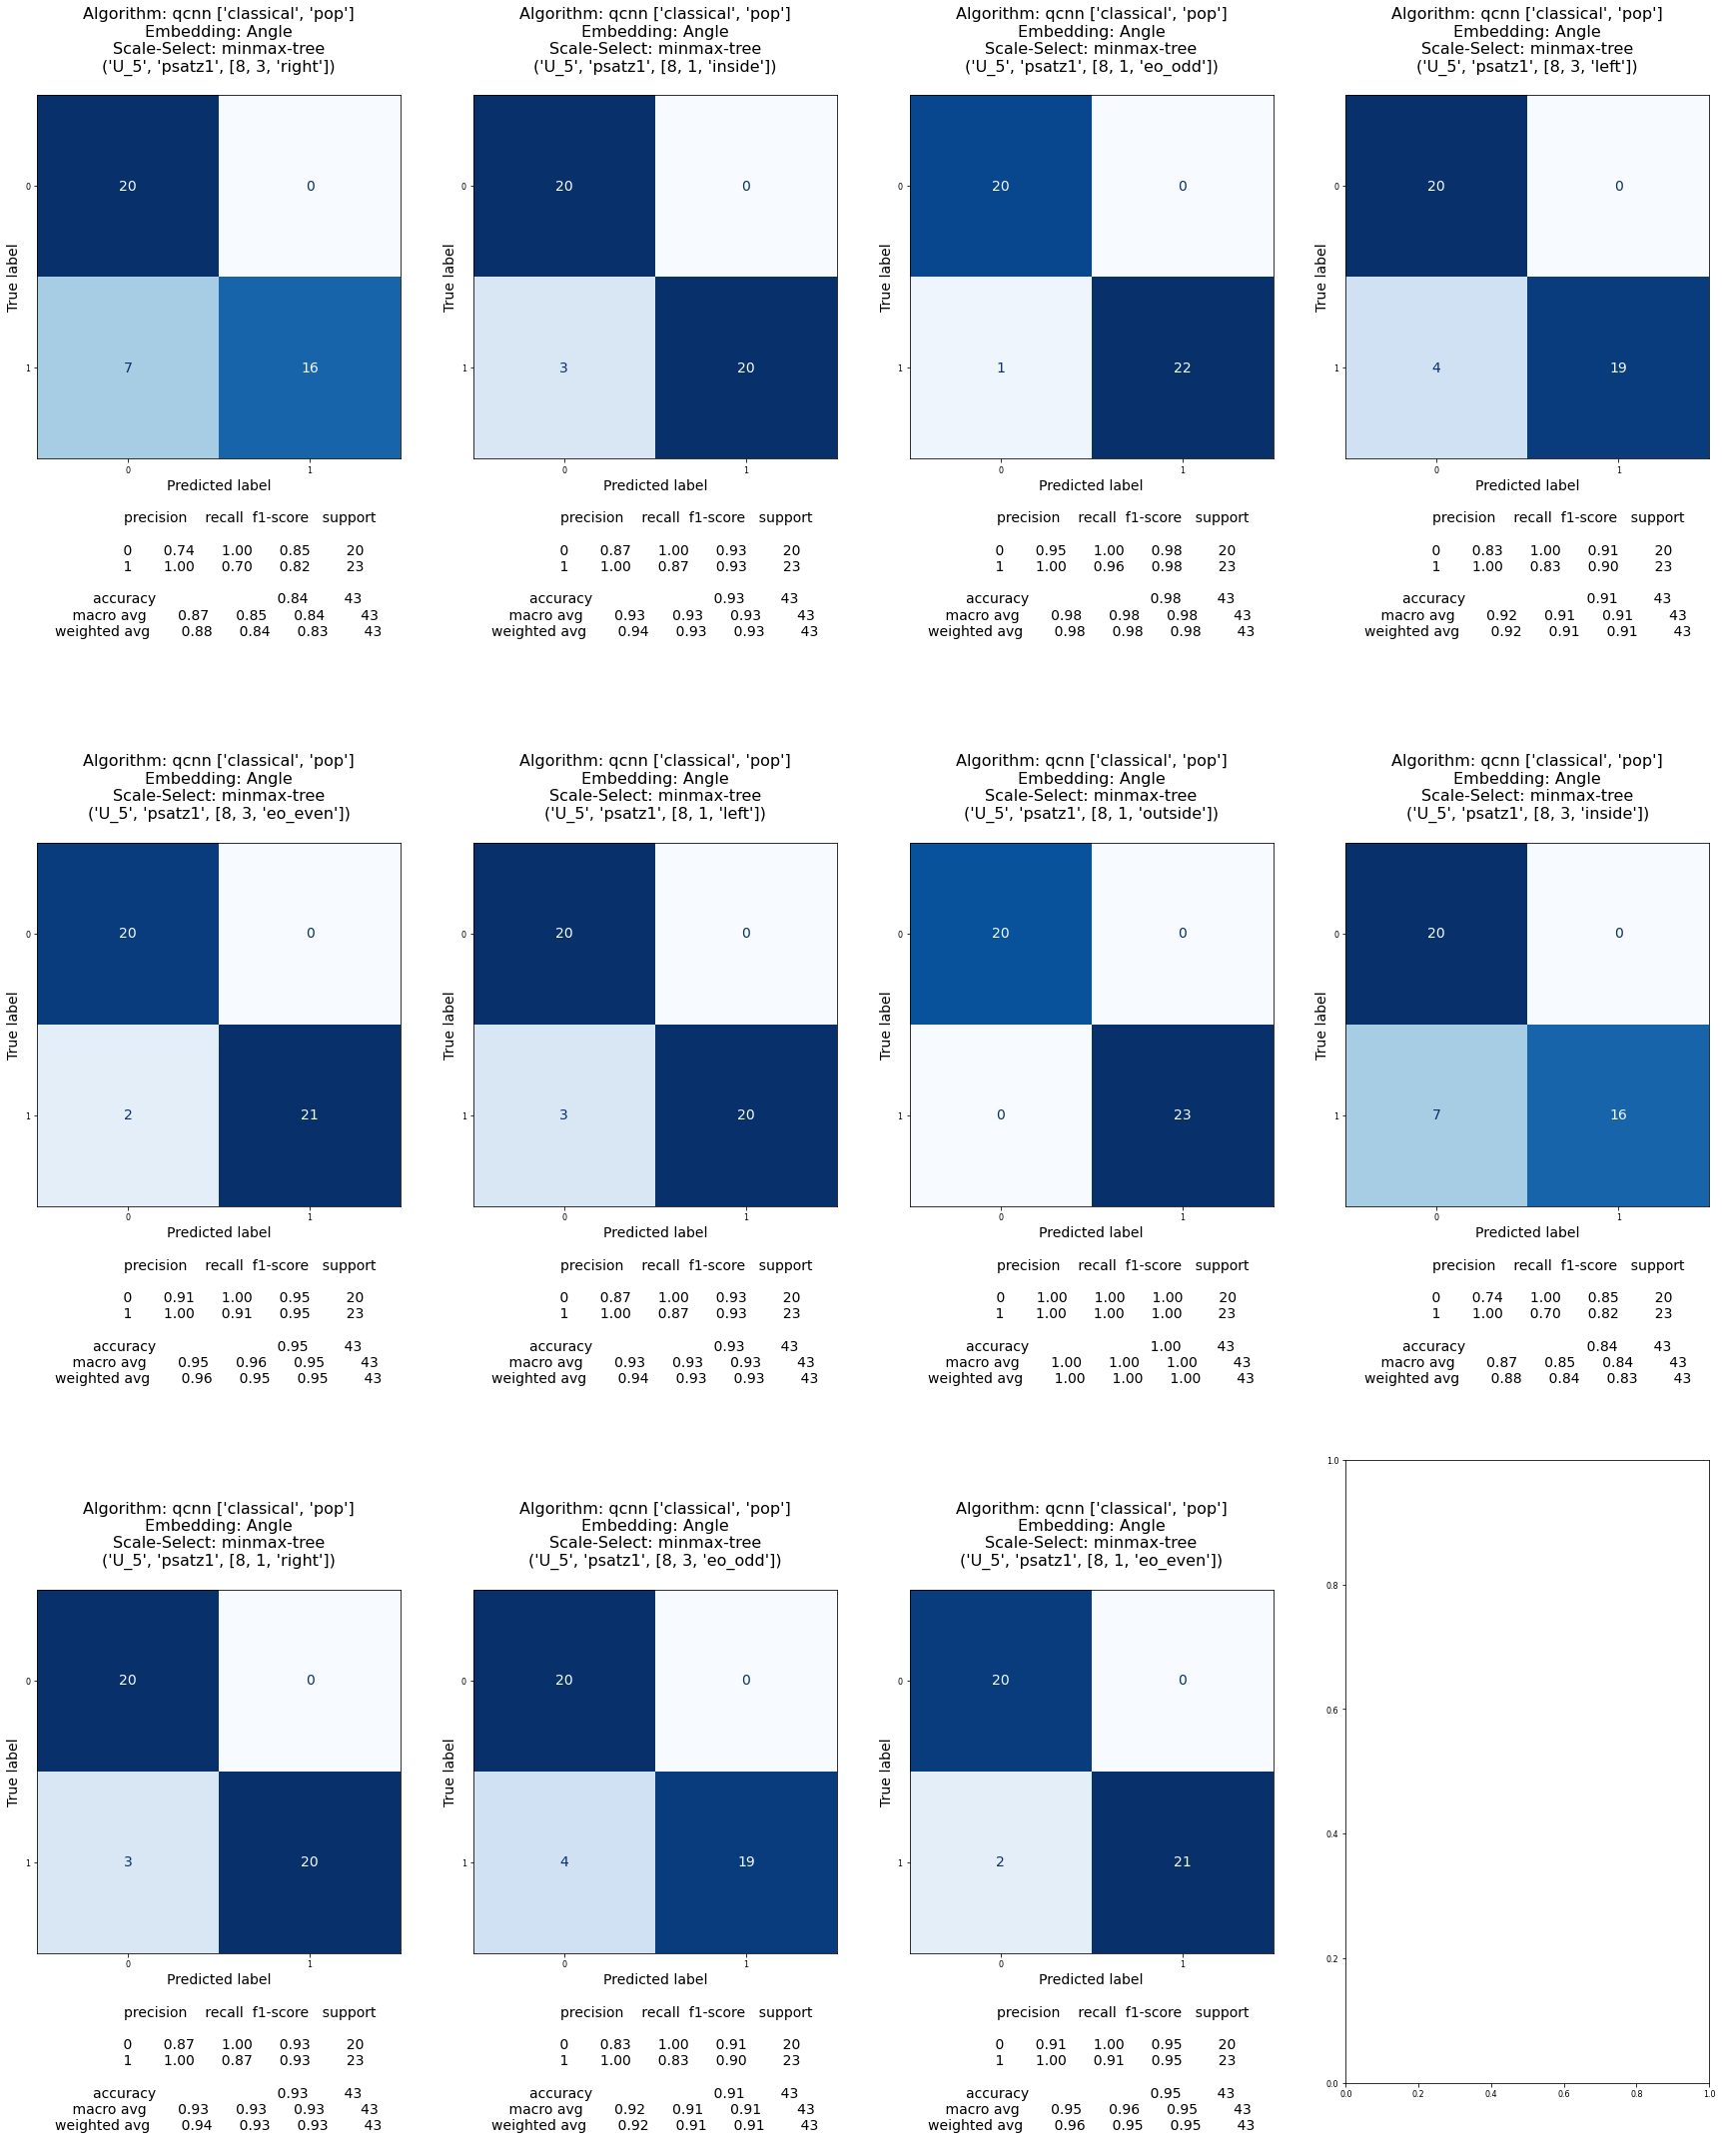

<Figure size 432x288 with 0 Axes>

In [29]:
%matplotlib inline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import matplotlib.pyplot as plt

# Customize matplotlib
SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc("font", size=MEDIUM_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

row_width = 30
row_height = 13
columns_in_row = 4
n_plots = len(filtered_results)
n_rows = int(np.ceil(n_plots / columns_in_row))
fig, axes = plt.subplots(n_rows, columns_in_row, figsize=(row_width, n_rows * row_height))
for result, i in zip(filtered_results, range(n_plots)):
    col = i % columns_in_row
    row = int(np.floor(i / columns_in_row))
    y_test_hat = result.y_test_hat
    clf = result.clf
    model_configuration = result.model_configuration
    samples_tfd = result.samples_tfd
    model_name = result.model_name

    display_report = classification_report(samples_tfd.y_test, y_test_hat)
    title_text = (
        f"Algorithm: {model_configuration.algorithm} {model_configuration.target_pair}\n"
        f"Embedding: {model_configuration.embedding_type}\n"
        f"Scale-Select: {model_configuration.scaler_method}-{model_configuration.selection_method}\n"
        f"{model_configuration.additional_structure}\n"
    )
    axes[row, col].grid(False)
    ConfusionMatrixDisplay.from_predictions(
        samples_tfd.y_test, y_test_hat, ax=axes[row, col], cmap=plt.cm.Blues
    )

    axes[row, col].set_title(title_text)
    axes[row, col].set_xlabel(f"Predicted label\n\n{display_report}")
    im = axes[row, col].images
    cb = im[-1].colorbar
    cb.remove()


plt.close()
plt.tight_layout()
fig